In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qhdopt import QHD
from qhdopt.utils.benchmark_utils import run_test, compare_coarse_and_refine, make_violin_plot

In [3]:
from sympy import symbols, exp

def get_Q_b(problem_num):
    with open(f"resources/50d_instance{problem_num}.npy", 'rb') as f:
        Q = np.load(f)
        b = np.load(f)
        # global_sol = np.load(f)
    return Q, b

def create_sympy_func(Q, b):
    x = symbols(f"x:{len(Q)}")
    f = 0
    for i in range(len(Q)):
        qii = Q[i][i]
        bi = b[i]
        f += 0.5 * qii * exp(x[i]) * exp(x[i]) + bi * exp(-x[i])
    for i in range(len(Q)):
        for j in range(i + 1, len(Q)):
            f += Q[i][j] * exp(x[i]) * exp(x[j])
    return f, list(x)

In [4]:
resolution = 4
anneal_schedule = [[0,0],[20, 1]]
numruns = 1000
backend = "dwave"
tol = 1e-3
api_key_file = "dwave_api_key.txt" 
embedding_scheme = "unary"
NUM_PROBLEMS = 5

In [5]:
QP_problems = [get_Q_b(i) for i in range(1, NUM_PROBLEMS + 1)]
data = np.zeros((len(QP_problems)*2, 16))

## Test problem instances 1 - 10

In [5]:
# QP Problems
for i in range(NUM_PROBLEMS):
    print(f"Test problem {i}:")
    model = QHD.QP(*QP_problems[i])
    model.dwave_setup(resolution, numruns, api_key_from_file=api_key_file, 
                      embedding_scheme=embedding_scheme, 
                      anneal_schedule=anneal_schedule,
                      post_processing_method="IPOPT")
    data[i] = run_test(model)

Test problem 0:

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Test problem 1:
Test problem 2:
Test problem 3:
Test problem 4:


In [7]:
# Non-QP Problems
for i in range(NUM_PROBLEMS):
    data_i = NUM_PROBLEMS + i
    print(f"Test problem {i}:")
    model = QHD.SymPy(*create_sympy_func(*QP_problems[i]))
    model.dwave_setup(resolution, numruns, 
                      api_key_from_file=api_key_file, 
                      embedding_scheme=embedding_scheme, 
                      anneal_schedule=anneal_schedule,
                      post_processing_method="IPOPT")
    data[data_i] = run_test(model)

Test problem 0:
Test problem 1:
Test problem 2:
Test problem 3:
Test problem 4:


## Investigate the role of refinement

In [6]:
plot_data = []

for i in range(10):
    print(f"Test problem {i+1}:")
    if i < 5:
        model = QHD.QP(*QP_problems[i])
    else:
        model = QHD.SymPy(*create_sympy_func(*QP_problems[i-5]))
    model.dwave_setup(resolution, numruns, api_key_from_file=api_key_file, embedding_scheme=embedding_scheme, anneal_schedule=anneal_schedule,post_processing_method="TNC")
    data = compare_coarse_and_refine(i+1, model)
    plot_data.append(data)

Test problem 1:
Backend QPU Time: 0.14132836
Overhead Time: 7.379592870316162

* Runtime breakdown
SimuQ compilation: 0.001 s
Backend runtime: 7.521 s
Decoding time: 0.233 s
Classical (Fine-tuning) time: 2.133 s
* Total time: 9.888 s

* Coarse solution
Minimizer: [0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  1.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.
 1.  1.  0.  0.  0.  0.5 1.  0.  0.  0.  0.  0.  0.  0. ]
Minimum: -1.1873167707228696

* Fine-tuned solution
Minimizer: [0.         0.         0.         0.         0.         0.
 0.         0.         1.         1.         0.         1.
 0.         0.         0.         0.         1.         1.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         1.         0.
 1.         1.         0.         0.         0.         0.59351027
 1.         0.         0.         0.         0.   

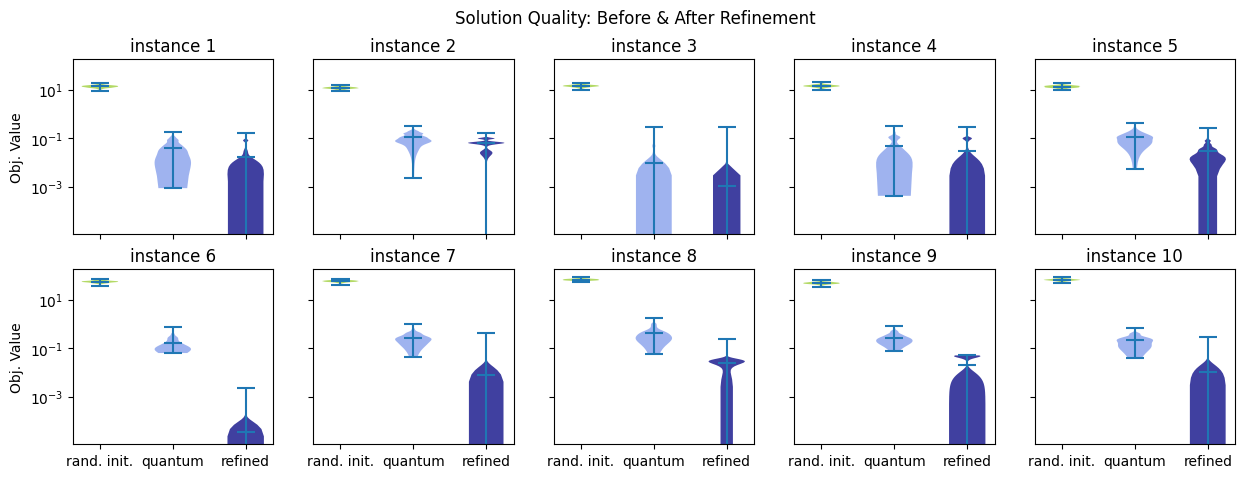

In [11]:
make_violin_plot(plot_data)